In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

from track_linearization import get_linearized_position

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    path = "/Users/edeno/Downloads/"
    animal_date_epoch = "j1620210710_02_r1"
    position_info = pd.read_pickle(path + f"{animal_date_epoch}_position_info.pkl")
    spike_times = joblib.load(path + f"{animal_date_epoch}_HPC_spike_times.pkl")
    track_graph = joblib.load(path + f"{animal_date_epoch}_track_graph.pkl")
    linear_edge_order = joblib.load(path + f"{animal_date_epoch}_linear_edge_order.pkl")
    linear_edge_spacing = joblib.load(
        path + f"{animal_date_epoch}_linear_edge_spacing.pkl"
    )

    return (
        position_info,
        spike_times,
        track_graph,
        linear_edge_order,
        linear_edge_spacing,
    )


position_info, spike_times, track_graph, edge_order, edge_spacing = load_data()
edge_spacing = 1.5
time = position_info.index
position2D = position_info[["head_position_x", "head_position_y"]].to_numpy()
position = get_linearized_position(
    position2D,
    track_graph,
    edge_order,
    edge_spacing,
).linear_position.values

In [4]:
from non_local_detector import Environment

env = Environment(
    track_graph=track_graph,
    edge_order=edge_order,
    edge_spacing=edge_spacing,
)
env

Environment(environment_name='', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x18093bc20>, edge_order=[(9, 6), (6, 0), (6, 1), (9, 7), (7, 2), (7, 3), (9, 8), (8, 4), (8, 5)], edge_spacing=1.5, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0, edges_=None, place_bin_edges_=None, place_bin_centers_=None, centers_shape_=None, is_track_interior_=None, is_track_boundary_=None, track_graphDD=None, distance_between_nodes_=None, track_graph_with_bin_centers_edges_=None, original_nodes_df_=None, place_bin_edges_nodes_df_=None, place_bin_centers_nodes_df_=None, nodes_df_=None, _is_fitted=False)

In [5]:
from non_local_detector.models import (
    NonLocalSortedSpikesDetector,
    ContFragSortedSpikesClassifier,
    SortedSpikesDecoder,
)

cont_model = SortedSpikesDecoder(
    environments=env,
).fit(
    spike_times=spike_times,
    position=position2D,
    position_time=time,
)

cont_frag_model = ContFragSortedSpikesClassifier(
    environments=env,
).fit(
    spike_times=spike_times,
    position=position2D,
    position_time=np.asarray(time),
)

# non_local_model = NonLocalSortedSpikesDetector(
#     environments=env,
# ).fit(
#     spike_times=spike_times,
#     position=position,
#     position_time=np.asarray(time),
# )

25-Jun-25 17:16:48 Fitting initial conditions...
25-Jun-25 17:16:48 Fitting discrete state transition
25-Jun-25 17:16:48 Fitting continuous state transition...
25-Jun-25 17:16:50 Fitting place fields...
25-Jun-25 17:16:50 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
25-Jun-25 17:16:50 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

25-Jun-25 17:17:35 Fitting initial conditions...
25-Jun-25 17:17:35 Fitting discrete state transition
25-Jun-25 17:17:35 Fitting continuous state transition...
25-Jun-25 17:17:36 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

In [6]:
cont_results = cont_model.predict(
    spike_times=spike_times,
    time=time,
    position_time=time,
    position=position2D,
    save_log_likelihood_to_results=True,
    cache_likelihood=True,
)

cont_frag_results = cont_frag_model.predict(
    spike_times=spike_times,
    time=time,
    position_time=time,
    position=position2D,
    save_log_likelihood_to_results=True,
    cache_likelihood=True,
)

# non_local_results = non_local_classifier.predict(
#     spike_times=spike_times,
#     time=time,
#     position_time=time,
#     position=position,
#     cache_likelihood=True,
# )

25-Jun-25 17:20:47 Computing posterior...
25-Jun-25 17:20:47 Computing log likelihood...


Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1222: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(
25-Jun-25 17:22:21 Computing posterior...
25-Jun-25 17:22:21 Computing log likelihood...


Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1222: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


In [7]:
from non_local_detector.model_checking.posterior_consistency import (
    posterior_consistency_hpd_overlap,
)

cont_hpd_overlap = posterior_consistency_hpd_overlap(
    posterior=cont_results.acausal_posterior.dropna("state_bins").to_numpy(),
    likelihood=np.exp(cont_results.log_likelihood.dropna("state_bins").to_numpy()),
)
cont_frag_hpd_overlap = posterior_consistency_hpd_overlap(
    posterior=cont_frag_results.acausal_posterior.dropna("state_bins").to_numpy(),
    likelihood=np.exp(cont_frag_results.log_likelihood.dropna("state_bins").to_numpy()),
)

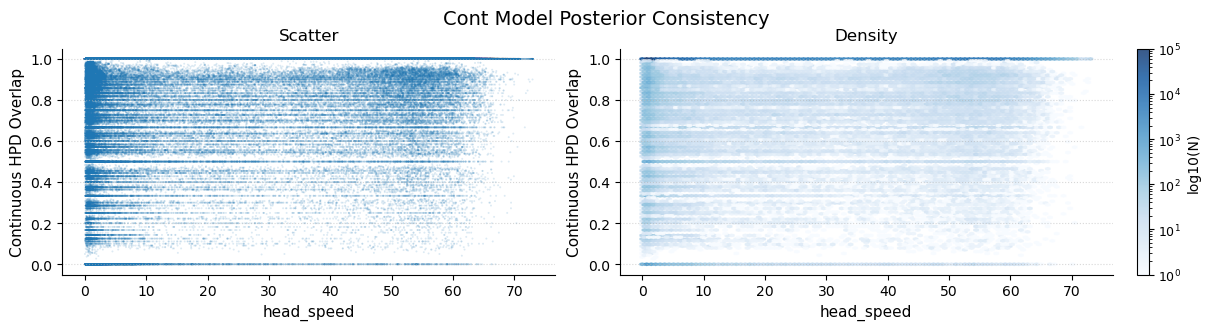

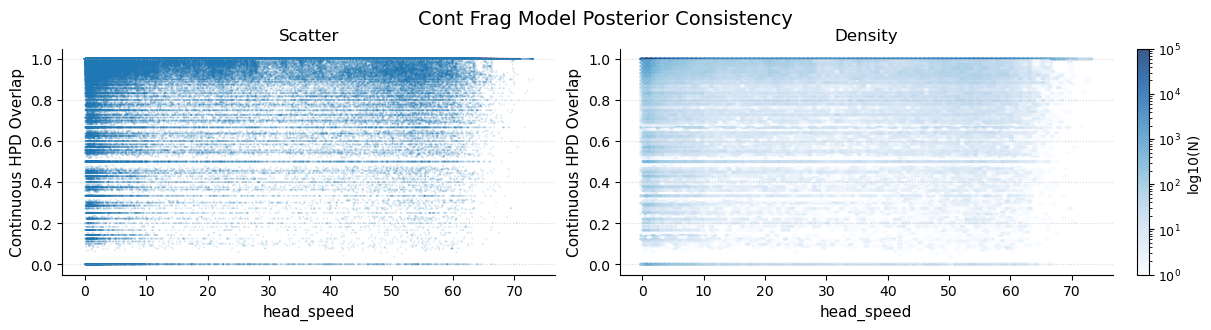

In [ ]:
import matplotlib.pyplot as plt


def plot_posterior_consistency_vs_covariate(
    covariate,
    covariate_label=None,
    hpd_overlap=None,
    position_info=None,
    gridsize=100,
    alpha_scatter=0.15,
    scatter_size=2,
    cmap="Blues",
    bins="log",
    mincnt=1,
    figsize=(12, 3),
    suptitle=None,
):
    """
    Plot posterior consistency (HPD overlap) vs a covariate using scatter and hexbin plots.

    Parameters
    ----------
    covariate : str
        Column name in position_info to use as x-axis.
    covariate_label : str or None
        Label for x-axis. If None, uses covariate.
    hpd_overlap : np.ndarray or pd.Series
        Array of HPD overlap values.
    position_info : pd.DataFrame
        DataFrame containing covariate.
    gridsize : int
        Hexbin grid size.
    alpha_scatter : float
        Alpha for scatter plot.
    scatter_size : float
        Marker size for scatter plot.
    cmap : str
        Colormap for hexbin.
    bins : str
        Binning for hexbin.
    mincnt : int
        Minimum count for hexbin.
    figsize : tuple
        Figure size.
    suptitle : str or None
        Figure super-title.
    """
    if covariate_label is None:
        covariate_label = covariate
    if suptitle is None:
        suptitle = f"Posterior Consistency vs {covariate_label}"

    x = position_info[covariate]
    y = hpd_overlap

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # Scatter plot
    ax1.scatter(
        x, y, s=scatter_size, alpha=alpha_scatter, color="tab:blue", edgecolor="none"
    )
    ax1.set_xlabel(covariate_label, fontsize=11)
    ax1.set_ylabel("Continuous HPD Overlap", fontsize=11)
    ax1.set_title("Scatter", fontsize=12)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.yaxis.grid(True, linestyle=":", alpha=0.5)
    ax1.xaxis.grid(False)

    # Hexbin plot
    hb = ax2.hexbin(
        x, y, gridsize=gridsize, cmap=cmap, bins=bins, mincnt=mincnt, alpha=0.8
    )
    ax2.set_xlabel(covariate_label, fontsize=11)
    ax2.set_ylabel("Continuous HPD Overlap", fontsize=11)
    ax2.set_title("Density", fontsize=12)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.yaxis.grid(True, linestyle=":", alpha=0.5)
    ax2.xaxis.grid(False)
    cb = plt.colorbar(hb, ax=ax2, label="log10(N)")
    cb.ax.tick_params(labelsize=9)

    fig.suptitle(suptitle, fontsize=14, y=1.05)


# Example usage:
plot_posterior_consistency_vs_covariate(
    covariate="head_speed",
    hpd_overlap=cont_hpd_overlap,
    position_info=position_info,
    suptitle="Cont Model Posterior Consistency",
)

plot_posterior_consistency_vs_covariate(
    covariate="head_speed",
    hpd_overlap=cont_frag_hpd_overlap,
    position_info=position_info,
    suptitle="Cont Frag Model Posterior Consistency",
)

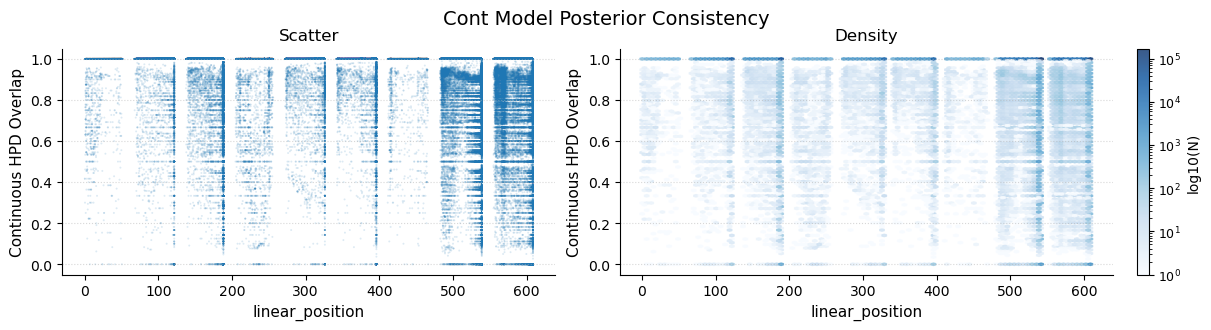

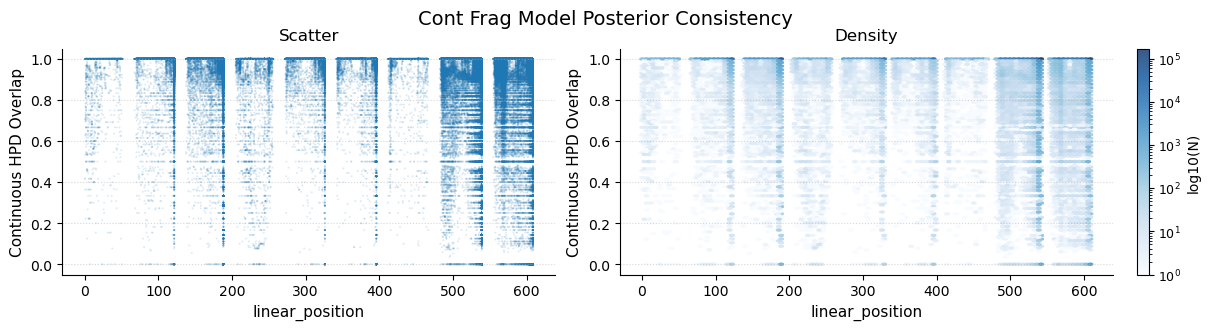

In [46]:
plot_posterior_consistency_vs_covariate(
    covariate="linear_position",
    hpd_overlap=cont_hpd_overlap,
    position_info=position_info,
    suptitle="Cont Model Posterior Consistency",
)
plot_posterior_consistency_vs_covariate(
    covariate="linear_position",
    hpd_overlap=cont_frag_hpd_overlap,
    position_info=position_info,
    suptitle="Cont Frag Model Posterior Consistency",
)

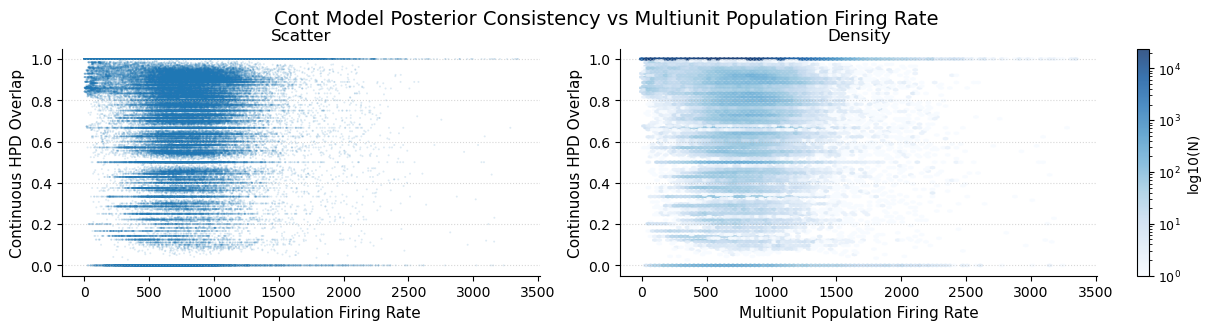

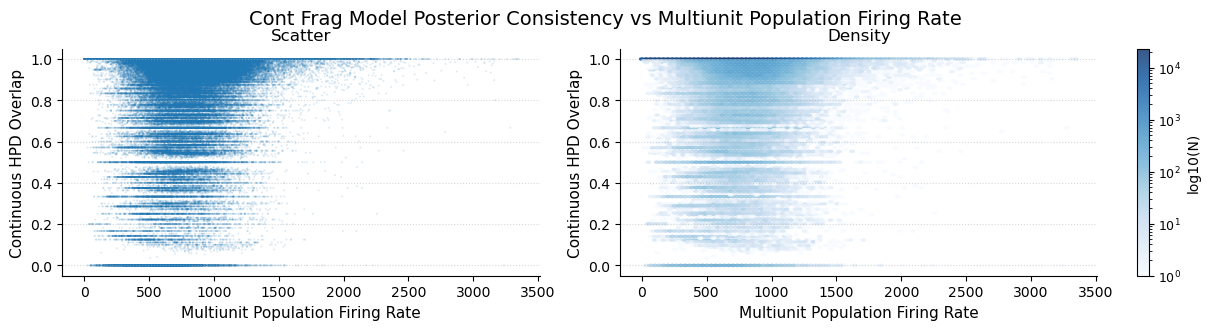

In [51]:
from scipy.ndimage import gaussian_filter1d
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin


def gaussian_smooth(data, sigma, sampling_frequency, axis=0, truncate=8):
    """1D convolution of the data with a Gaussian.

    The standard deviation of the gaussian is in the units of the sampling
    frequency. The function is just a wrapper around scipy's
    `gaussian_filter1d`, The support is truncated at 8 by default, instead
    of 4 in `gaussian_filter1d`

    Parameters
    ----------
    data : array_like
    sigma : float
    sampling_frequency : int
    axis : int, optional
    truncate : int, optional

    Returns
    -------
    smoothed_data : array_like

    """
    return gaussian_filter1d(
        data, sigma * sampling_frequency, truncate=truncate, axis=axis, mode="constant"
    )


def get_multiunit_population_firing_rate(
    multiunit, sampling_frequency, smoothing_sigma=0.015
):
    """Calculates the multiunit population firing rate.

    Parameters
    ----------
    multiunit : ndarray, shape (n_time, n_signals)
        Binary array of multiunit spike times.
    sampling_frequency : float
        Number of samples per second.
    smoothing_sigma : float or np.timedelta
        Amount to smooth the firing rate over time. The default is
        given assuming time is in units of seconds.


    Returns
    -------
    multiunit_population_firing_rate : ndarray, shape (n_time,)

    """
    return gaussian_smooth(
        multiunit.sum(axis=1) * sampling_frequency, smoothing_sigma, sampling_frequency
    )


spikecount = np.stack(
    [
        get_spikecount_per_time_bin(
            spike_times=st,
            time=time,
        )
        for st in spike_times
    ],
    axis=1,
)

multiunit_population_firing_rate = get_multiunit_population_firing_rate(
    multiunit=spikecount,
    sampling_frequency=1 / (time[1] - time[0]),
    smoothing_sigma=0.015,
)


def plot_posterior_consistency_vs_covariate2(
    x,
    covariate_label=None,
    hpd_overlap=None,
    gridsize=100,
    alpha_scatter=0.15,
    scatter_size=2,
    cmap="Blues",
    bins="log",
    mincnt=1,
    figsize=(12, 3),
    suptitle=None,
):
    y = hpd_overlap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # Scatter plot
    ax1.scatter(
        x, y, s=scatter_size, alpha=alpha_scatter, color="tab:blue", edgecolor="none"
    )
    ax1.set_xlabel(covariate_label, fontsize=11)
    ax1.set_ylabel("Continuous HPD Overlap", fontsize=11)
    ax1.set_title("Scatter", fontsize=12)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.yaxis.grid(True, linestyle=":", alpha=0.5)
    ax1.xaxis.grid(False)

    # Hexbin plot
    hb = ax2.hexbin(
        x, y, gridsize=gridsize, cmap=cmap, bins=bins, mincnt=mincnt, alpha=0.8
    )
    ax2.set_xlabel(covariate_label, fontsize=11)
    ax2.set_ylabel("Continuous HPD Overlap", fontsize=11)
    ax2.set_title("Density", fontsize=12)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.yaxis.grid(True, linestyle=":", alpha=0.5)
    ax2.xaxis.grid(False)
    cb = plt.colorbar(hb, ax=ax2, label="log10(N)")
    cb.ax.tick_params(labelsize=9)

    fig.suptitle(suptitle, fontsize=14, y=1.05)

plot_posterior_consistency_vs_covariate2(
    x=multiunit_population_firing_rate,
    covariate_label="Multiunit Population Firing Rate",
    hpd_overlap=cont_hpd_overlap,
    suptitle="Cont Model Posterior Consistency vs Multiunit Population Firing Rate",
)
plot_posterior_consistency_vs_covariate2(
    x=multiunit_population_firing_rate,
    covariate_label="Multiunit Population Firing Rate",
    hpd_overlap=cont_frag_hpd_overlap,
    suptitle="Cont Frag Model Posterior Consistency vs Multiunit Population Firing Rate",
)

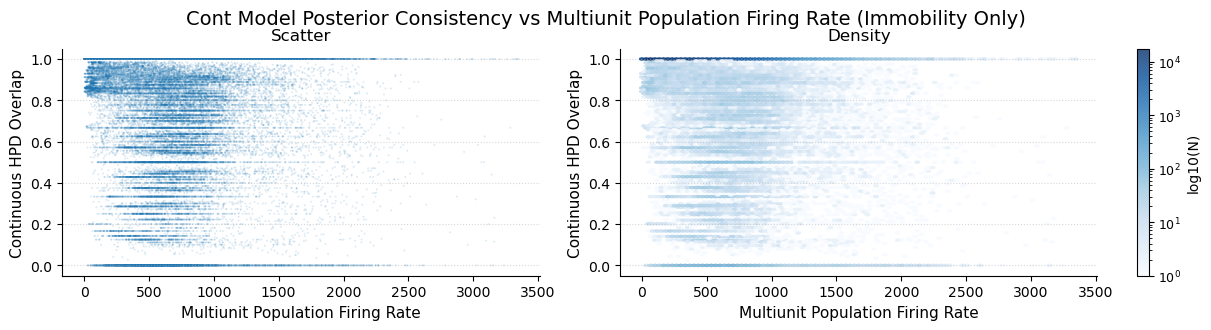

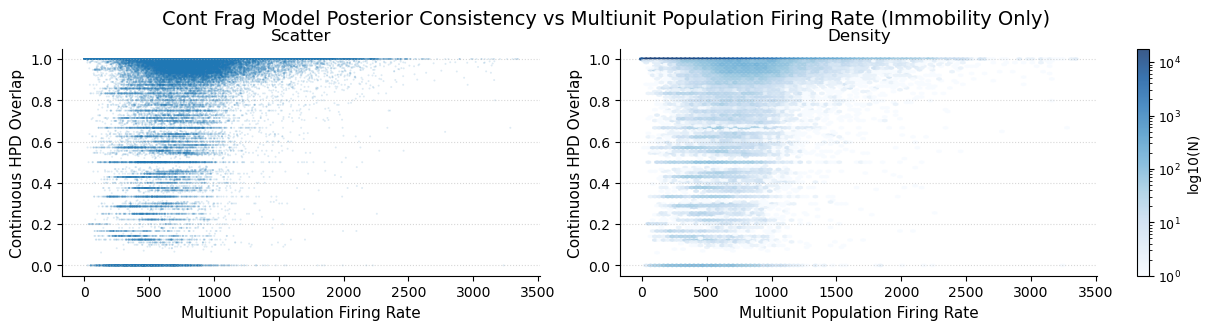

In [54]:
head_speed_interp = (
    pd.Series(position_info["head_speed"].values, index=position_info.index)
    .reindex(time)
    .interpolate()
    .values
)
immobility_mask = head_speed_interp < 4.0

plot_posterior_consistency_vs_covariate2(
    x=multiunit_population_firing_rate[immobility_mask],
    covariate_label="Multiunit Population Firing Rate",
    hpd_overlap=cont_hpd_overlap[immobility_mask],
    suptitle="Cont Model Posterior Consistency vs Multiunit Population Firing Rate (Immobility Only)",
)
plot_posterior_consistency_vs_covariate2(
    x=multiunit_population_firing_rate[immobility_mask],
    covariate_label="Multiunit Population Firing Rate",
    hpd_overlap=cont_frag_hpd_overlap[immobility_mask],
    suptitle="Cont Frag Model Posterior Consistency vs Multiunit Population Firing Rate (Immobility Only)",
)

In [33]:
position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed,linear_position,track_segment_id,projected_x_position,projected_y_position,patch_id
time,,,,,,,,,,,
1.625936e+09,132.441482,137.211733,1.258303,-1.701742,27.848269,27.900215,213.265636,7,135.567726,137.221105,2
1.625936e+09,132.438802,137.286771,1.253217,-1.631356,27.814859,27.862658,213.340681,7,135.567501,137.296150,2
1.625936e+09,132.436122,137.361809,1.248116,-1.560218,27.779452,27.823231,213.415727,7,135.567276,137.371195,2
1.625936e+09,132.433442,137.436846,1.243001,-1.488372,27.742060,27.781958,213.490772,7,135.567051,137.446240,2
1.625936e+09,132.430762,137.511884,1.237872,-1.415862,27.702700,27.738858,213.565817,7,135.566826,137.521285,2
...,...,...,...,...,...,...,...,...,...,...,...
1.625937e+09,38.440725,113.561469,-1.404053,0.710201,-0.741198,1.026528,531.000045,4,44.771321,124.425853,3
1.625937e+09,38.438045,113.561469,-1.405116,0.690925,-0.726376,1.002496,531.002361,4,44.769320,124.427018,3
1.625937e+09,38.435365,113.561469,-1.406177,0.671855,-0.711611,0.978662,531.004676,4,44.767319,124.428184,3


In [13]:
cont_hpd_overlap.mean(), cont_frag_hpd_overlap.mean(), cont_frag_hpd_overlap.mean() - cont_hpd_overlap.mean()

(np.float64(0.9561781576031253),
 np.float64(0.9654904558308894),
 np.float64(0.009312298227764138))

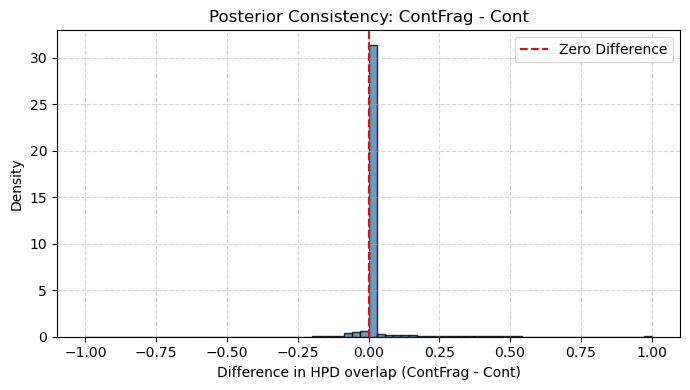

In [ ]:
import matplotlib.pyplot as plt

plt.hist(cont_frag_hpd_overlap - cont_hpd_overlap, bins=70, density=True)
plt.xlabel("Difference in HPD overlap")
plt.ylabel("Density")
plt.title("Posterior Consistency: ContFrag - Cont")
plt.axvline(0, color="red", linestyle="--", label="Zero Difference")
plt.legend()

/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_77193/3554052973.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


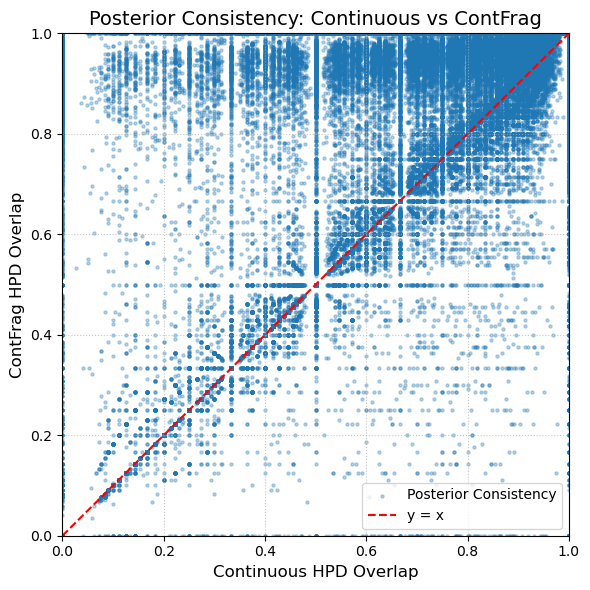

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    alpha=0.3,
    s=5,
    color="tab:blue",
    label="Posterior Consistency",
)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="y = x")
plt.xlabel("Continuous HPD Overlap", fontsize=12)
plt.ylabel("ContFrag HPD Overlap", fontsize=12)
plt.title("Posterior Consistency: Continuous vs ContFrag", fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend()
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import label


def plot_spike_times(spike_times, time_slice, ax=None, sort_order=None):
    if ax is None:
        ax = plt.gca()
    time_slice_spike_times = [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times < time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ]

    if sort_order is not None:
        time_slice_spike_times = [time_slice_spike_times[i] for i in sort_order]

    ax.eventplot(
        time_slice_spike_times,
        linelengths=0.5,
        colors="black",
        rasterized=True,
    )


def plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.2,
):

    time_slice = slice(time[time_slice_ind.start], time[time_slice_ind.stop])

    cont_frag_bad_overlap_labels, n_cont_frag_bad_overlap_labels = label(
        cont_frag_hpd_overlap[time_slice_ind] < overlap_threshold
    )

    cont_bad_overlap_labels, n_cont_bad_overlap_labels = label(
        cont_hpd_overlap[time_slice_ind] < overlap_threshold
    )

    sort_order = np.argsort(
        cont_model.environments[0]
        .place_bin_centers_[
            cont_model.encoding_model_[("", 0)]["place_fields"].argmax(axis=1)
        ]
        .squeeze()
    )

    fig, axes = plt.subplots(4, 1, figsize=(7, 8), sharex=True, constrained_layout=True)
    cont_results.acausal_posterior.isel(time=time_slice_ind).unstack("state_bins").sum(
        "state"
    ).plot(
        x="time",
        y="position",
        ax=axes[0],
        add_colorbar=False,
        robust=True,
        cmap="bone_r",
        rasterized=True,
    )
    axes[0].set_title("Continuous Decoder")
    axes[0].scatter(
        time[time_slice_ind],
        position[time_slice_ind],
        color="magenta",
        s=1,
        rasterized=True,
        clip_on=False,
    )

    for label_ in range(1, n_cont_bad_overlap_labels + 1):
        bad_overlap_ind = np.where(cont_bad_overlap_labels == label_)[0]
        axes[0].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:blue",
            alpha=0.5,
        )
        axes[2].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:blue",
            alpha=0.5,
        )

    cont_frag_results.acausal_posterior.isel(time=time_slice_ind).unstack(
        "state_bins"
    ).sum("state").plot(
        x="time",
        y="position",
        ax=axes[1],
        add_colorbar=False,
        robust=True,
        cmap="bone_r",
        rasterized=True,
    )
    axes[1].scatter(
        time[time_slice_ind],
        position[time_slice_ind],
        color="magenta",
        s=1,
        rasterized=True,
        clip_on=False,
    )
    axes[1].set_title("Continuous Fragmented Decoder")

    for label_ in range(1, n_cont_frag_bad_overlap_labels + 1):
        bad_overlap_ind = np.where(cont_frag_bad_overlap_labels == label_)[0]
        axes[1].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:orange",
            alpha=0.5,
        )
        axes[2].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:orange",
            alpha=0.5,
        )

    plot_spike_times(spike_times, time_slice, ax=axes[2], sort_order=sort_order)

    axes[3].plot(
        time[time_slice_ind], cont_hpd_overlap[time_slice_ind], label="Continuous"
    )
    axes[3].plot(
        time[time_slice_ind],
        cont_frag_hpd_overlap[time_slice_ind],
        label="Continuous Fragmented",
    )
    axes[3].legend()

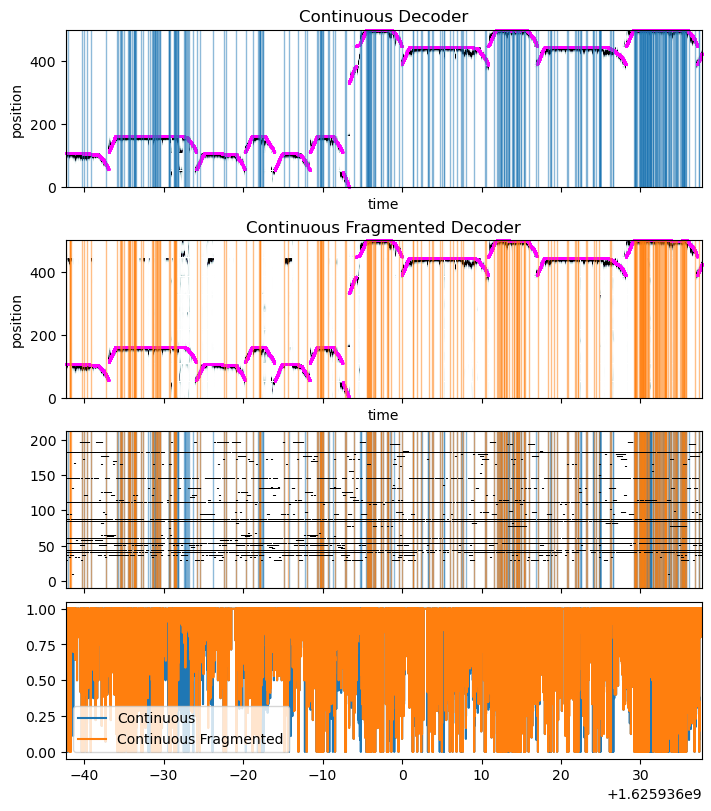

In [9]:
time_slice_ind = slice(100_000, 140_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1,
)

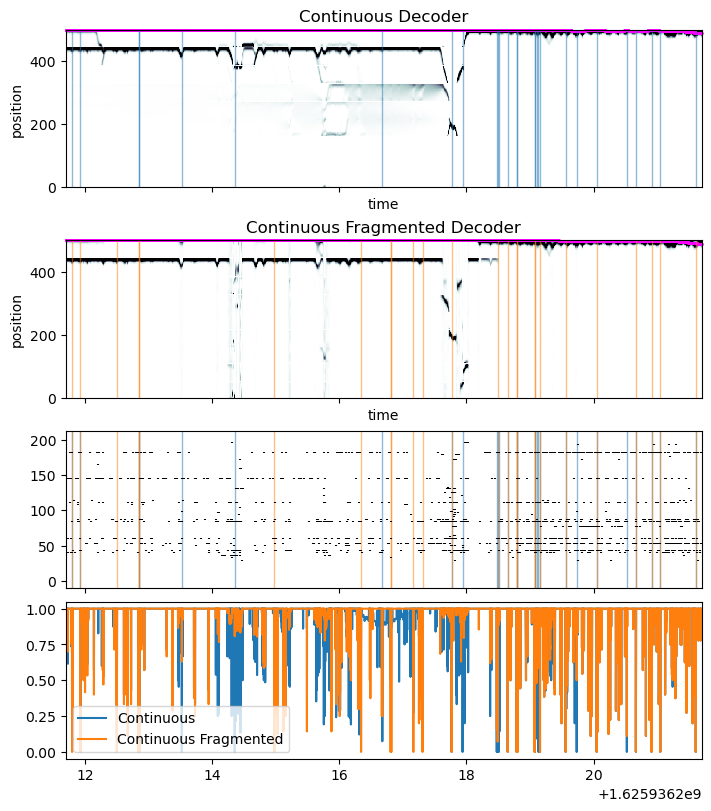

In [144]:
time_slice_ind = slice(227_000, 232_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1,
)

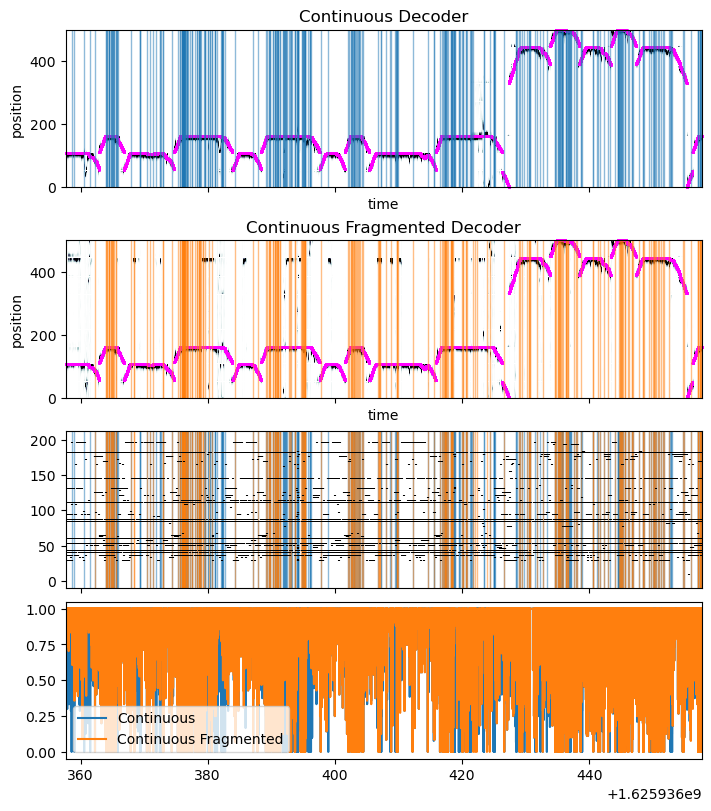

In [145]:
time_slice_ind = slice(300_000, 350_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1,
)

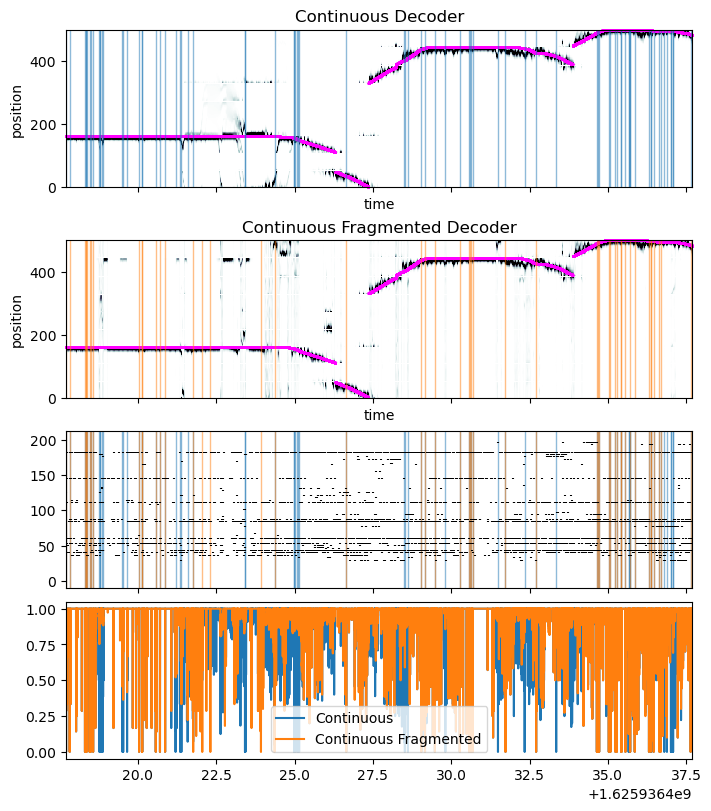

In [ ]:
from scipy.ndimage import label

time_slice_ind = slice(330_000, 340_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1,
)

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

Text(0.5, 0, 'Position')

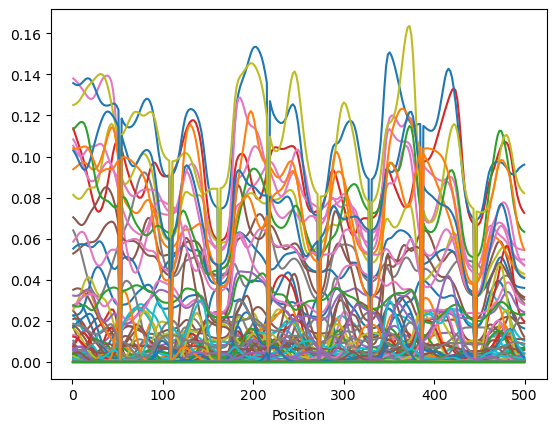

In [ ]:
plt.plot(
    cont_model.environments[0].place_bin_centers_,
    cont_model.encoding_model_[("", 0)]["place_fields"].T,
)
plt.xlabel("Position")

In [ ]:
cont_model.environments[0].place_bin_centers_

203

In [109]:
cont_model.encoding_model_[("", 0)]["place_fields"].shape

(203, 256)